<a href="https://colab.research.google.com/github/Chandra0505/Video-Recommandation-System/blob/Abhijeet/Research2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [0]:
genome_scores=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/genome-scores.csv")
genome_tags=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/genome-tags.csv")
links=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/links.csv")
movies=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/movies.csv")
ratings=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ratings.csv")
tags=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/tags.csv")

https://blog.codecentric.de/en/2019/07/recommender-system-movie-lens-dataset/

In [0]:
movies.tail()
movies['genres'] = movies['genres'].str.replace('|',' ')

In [4]:
len(movies.movieId.unique())

62423

In [5]:
len(ratings.movieId.unique())

59047

In [0]:
#limit ratings to user ratings that have rated more that 55 movies -- 
#Otherwise it becomes impossible to pivot the rating dataframe later for collaborative filtering.

ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)
ratings_f=ratings_f.sample(n=100000,random_state=5)

# list the movie titles that survive the filtering
movie_list_rating = ratings_f.movieId.unique().tolist()

In [0]:
#filter the movies data frame
movies = movies[movies.movieId.isin(movie_list_rating)]

In [8]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [0]:
# map movie to id:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [0]:
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1, inplace=True)

In [11]:
# create a mixed dataframe of movies title, genres 
# and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,791.0,Owned
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1048.0,imdb top 250
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1361.0,Pixar


In [12]:
# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                                          lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(
                                          lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Owned imdb top 250 Pixar Pixar time travel chi...
1,2,Jumanji (1995),Robin Williams time travel fantasy based on ch...
2,3,Grumpier Old Men (1995),funny best friend duringcreditsstinger fishing...


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(10555, 27618)


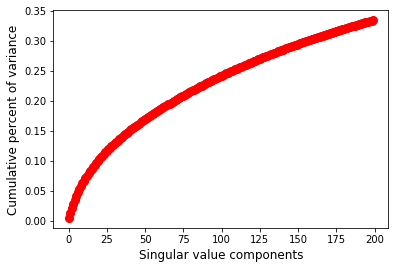

In [14]:
# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [0]:
#number of latent dimensions to keep
n = 200 
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

In [16]:
# our content latent matrix:
latent_matrix.shape

(10555, 200)


#### Creating a collaborative latent matrix from user ratings:

In [17]:
ratings_f.head()

,userId,movieId,rating
20409379,132693,30749,3.5
3973375,26154,1948,4.0
16708338,108337,246,5.0
7548962,49000,4703,5.0
15909771,103146,2144,3.5


In [18]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")
ratings_f1.head(3)

,movieId,userId,rating
0,1,141603,4.0
1,1,17500,2.0
2,1,26346,3.0


In [0]:
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [20]:
len(ratings_f.movieId.unique())

10555

In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(
                             latent_matrix_2,
                             index=Final.title.tolist())

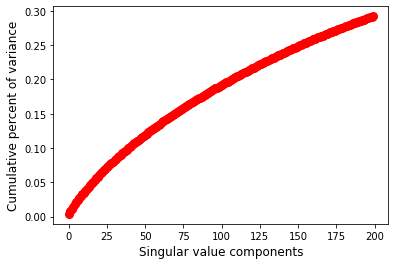

In [22]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Strada, La (1954)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc['Strada, La (1954)']).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
"Nights of Cabiria (Notti di Cabiria, Le) (1957)",0.695523,0.046135,0.370829
Mon Oncle (My Uncle) (1958),0.605792,-0.049632,0.278080
Day for Night (La Nuit Américaine) (1973),0.589705,-0.017553,0.286076
Moscow Does Not Believe in Tears (Moskva slezam ne verit) (1979),0.581015,0.102627,0.341821
Cries and Whispers (Viskningar och rop) (1972),0.566955,-0.059442,0.253757
"Shop on Main Street, The (Obchod na korze) (1965)",0.555529,-0.040633,0.257448
Fanny and Alexander (Fanny och Alexander) (1982),0.549880,-0.006912,0.271484
Kings of the Road (Im Lauf der Zeit) (1976),0.543375,0.108123,0.325749
Two-Lane Blacktop (1971),0.536902,0.020099,0.278500
Scenes From a Marriage (Scener ur ett äktenskap) (1973),0.517095,-0.004101,0.256497


### Use matrix factorization model:

In [24]:
!pip install surprise

In [0]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [26]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_f[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.9628


0.9628330469737283

In [0]:
def pred_user_rating(ui):
    if ui in ratings_f.userId.unique():
        ui_list = ratings_f[ratings_f.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [31]:
ratings_f.head()

,userId,movieId,rating
20409379,132693,30749,3.5
3973375,26154,1948,4.0
16708338,108337,246,5.0
7548962,49000,4703,5.0
15909771,103146,2144,3.5


In [32]:
user_id = 26154
pred_user_rating(user_id)

,ratings
movies,
Rear Window (1954),4.385030
"Godfather, The (1972)",4.363765
"Shawshank Redemption, The (1994)",4.341305
"Adventures of Robin Hood, The (1938)",4.309794
Casablanca (1942),4.274405
"Room with a View, A (1986)",4.262384
Cool Hand Luke (1967),4.253784
City Lights (1931),4.251804
His Girl Friday (1940),4.245580
